# An analysis on the sensitivity of TCR specificity to edit type


## Module imports and figure formatting

In [1]:
import pandas as pd
import numpy as np

#Pyrepseq imports
import pyrepseq as prs
import pyrepseq.plotting as rsp
import pyrepseq.distance as rsd
import pyrepseq.stats as rss

#Plotting imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.style 
import matplotlib as mpl 

In [2]:
#Set default plotting parameters
mpl.rcParams['figure.figsize'] = [4.0, 4.0] 
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=500 

SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Data imports 

### Mira - specific set

In [3]:
mira = pd.read_csv('../data/mira/processed/peptide-detail-ci.csv')
mira = mira.drop_duplicates("TCR Nucleotide Sequence")
mira = prs.standardize_dataframe(mira
                                        , [None, None, None ,
                               "v_gene", "amino_acid", "j_gene",
                    
                                           "Amino Acids", None, None, None])

mira = mira.dropna(axis=0, subset = ["CDR3B", "TRBV", "TRBJ"] ).reset_index().drop("index", axis=1)

#Ensure that there are enough sequences within each epitope so that we get some at distance 1
mira = mira.groupby(['Epitope']).filter(lambda x: len(x) > 200).reset_index().drop("index", axis=1)

/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV27-01" for species HomoSapiens. Attempted fix "TRBV27-1" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV30-01" for species HomoSapiens. Attempted fix "TRBV30-1" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV12-X" for species HomoSapiens. Attempted fix "TRBV12-X" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBV06-X" for species HomoSapiens. Attempted fix "TRBV6-X" did not meet the stan

/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TCRBJ02-X" for species HomoSapiens. Attempted fix "TRBJ2-X" did not meet the standardised format requirements. Ignoring this gene name...
  warn(


### Minervina - background

In [4]:
back = pd.read_csv('../data/minervina/beta/W_F1_2019_beta.txt.gz',sep='\t',index_col=0)
back = back.drop_duplicates("nSeqCDR3")
back = prs.standardize_dataframe(back
                                        , [None, None, None ,
                               "bestVGene", "aaSeqCDR3", "bestJGene",
                    
                                           None, None, None, None])

/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TRBV21-1" for species HomoSapiens. Attempted fix "TRBV21-1" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TRBV3-2" for species HomoSapiens. Attempted fix "TRBV3-2" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TRBV23-1" for species HomoSapiens. Attempted fix "TRBV23-1" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/Users/james/miniconda3/lib/python3.10/site-packages/tidytcells/tcr/_main.py:110: UserWarning: Failed to standardise: "TRBV12-1" for species HomoSapiens. Attempted fix "TRBV12-1" did not meet the standardise

## Probability of obtaining a given edit type for $\Delta = 1$

Here we will look at sequences which are an edit distance of $\Delta = 1$ away. We will count the number of pairs which are hamming distance 1 away, $N_{H}$, and the number of pairs levenshtein distance 1 away, $N_{L}$. The number of pairs which were then generated through a substitution, $N_{sub}$, are:

$$N_{sub} = N_{H}$$

while the number of pairs which were generated through an insertion or deletion are:

$$N_{in/del} = N_{L} - N_{H}$$

The probability of the edit being a substitution is therefore:

$$P(sub|\Delta = 1) = \frac{N_{sub}}{N_{sub}+N_{in/del}}$$

while the probability of the edit being an insertion or deletion is:

$$P(in/del|\Delta = 1) = \frac{N_{in/del}}{N_{sub}+N_{in/del}}$$

In [5]:
def p_edit_type(array, normalize = True):
    
    try:
        #Calculate the number of hamming neighbors
        sub_pairs = len(rsd.find_neighbor_pairs(array))
    
        #Calculate the number of levenshtein neighbors - subtract hamming neighbors to get insertion and deletions
        in_del_pairs = len(rsd.find_neighbor_pairs(array,rsd.levenshtein_neighbors)) - sub_pairs
    
        #Work out the total number of neighbors
        N_at_1 = sub_pairs+in_del_pairs
        
        if not normalize:
            return sub_pairs, in_del_pairs
        
        else:
            return (sub_pairs/N_at_1,in_del_pairs/N_at_1)
        
    except:
        return 0, 0

### Background analysis

Here we will run the analysis on the background set:

In [6]:
p_back = p_edit_type(back["CDR3B"])

### Specific analysis 

We will now run the same code but on mira sequences, grouped by their epitope

In [7]:
p_spc_sub = []
p_spc_indel = []

#Group data set via epitope
for epitope, group in mira.groupby('Epitope'):
    
    #Get the probabilities within each epitope
    sub,indel = p_edit_type(group["CDR3B"])
    
    p_spc_sub.append(sub)
    p_spc_indel.append(indel)
    
p_spc_sub = np.mean(p_spc_sub)
p_spc_indel = np.mean(p_spc_indel)

## Results

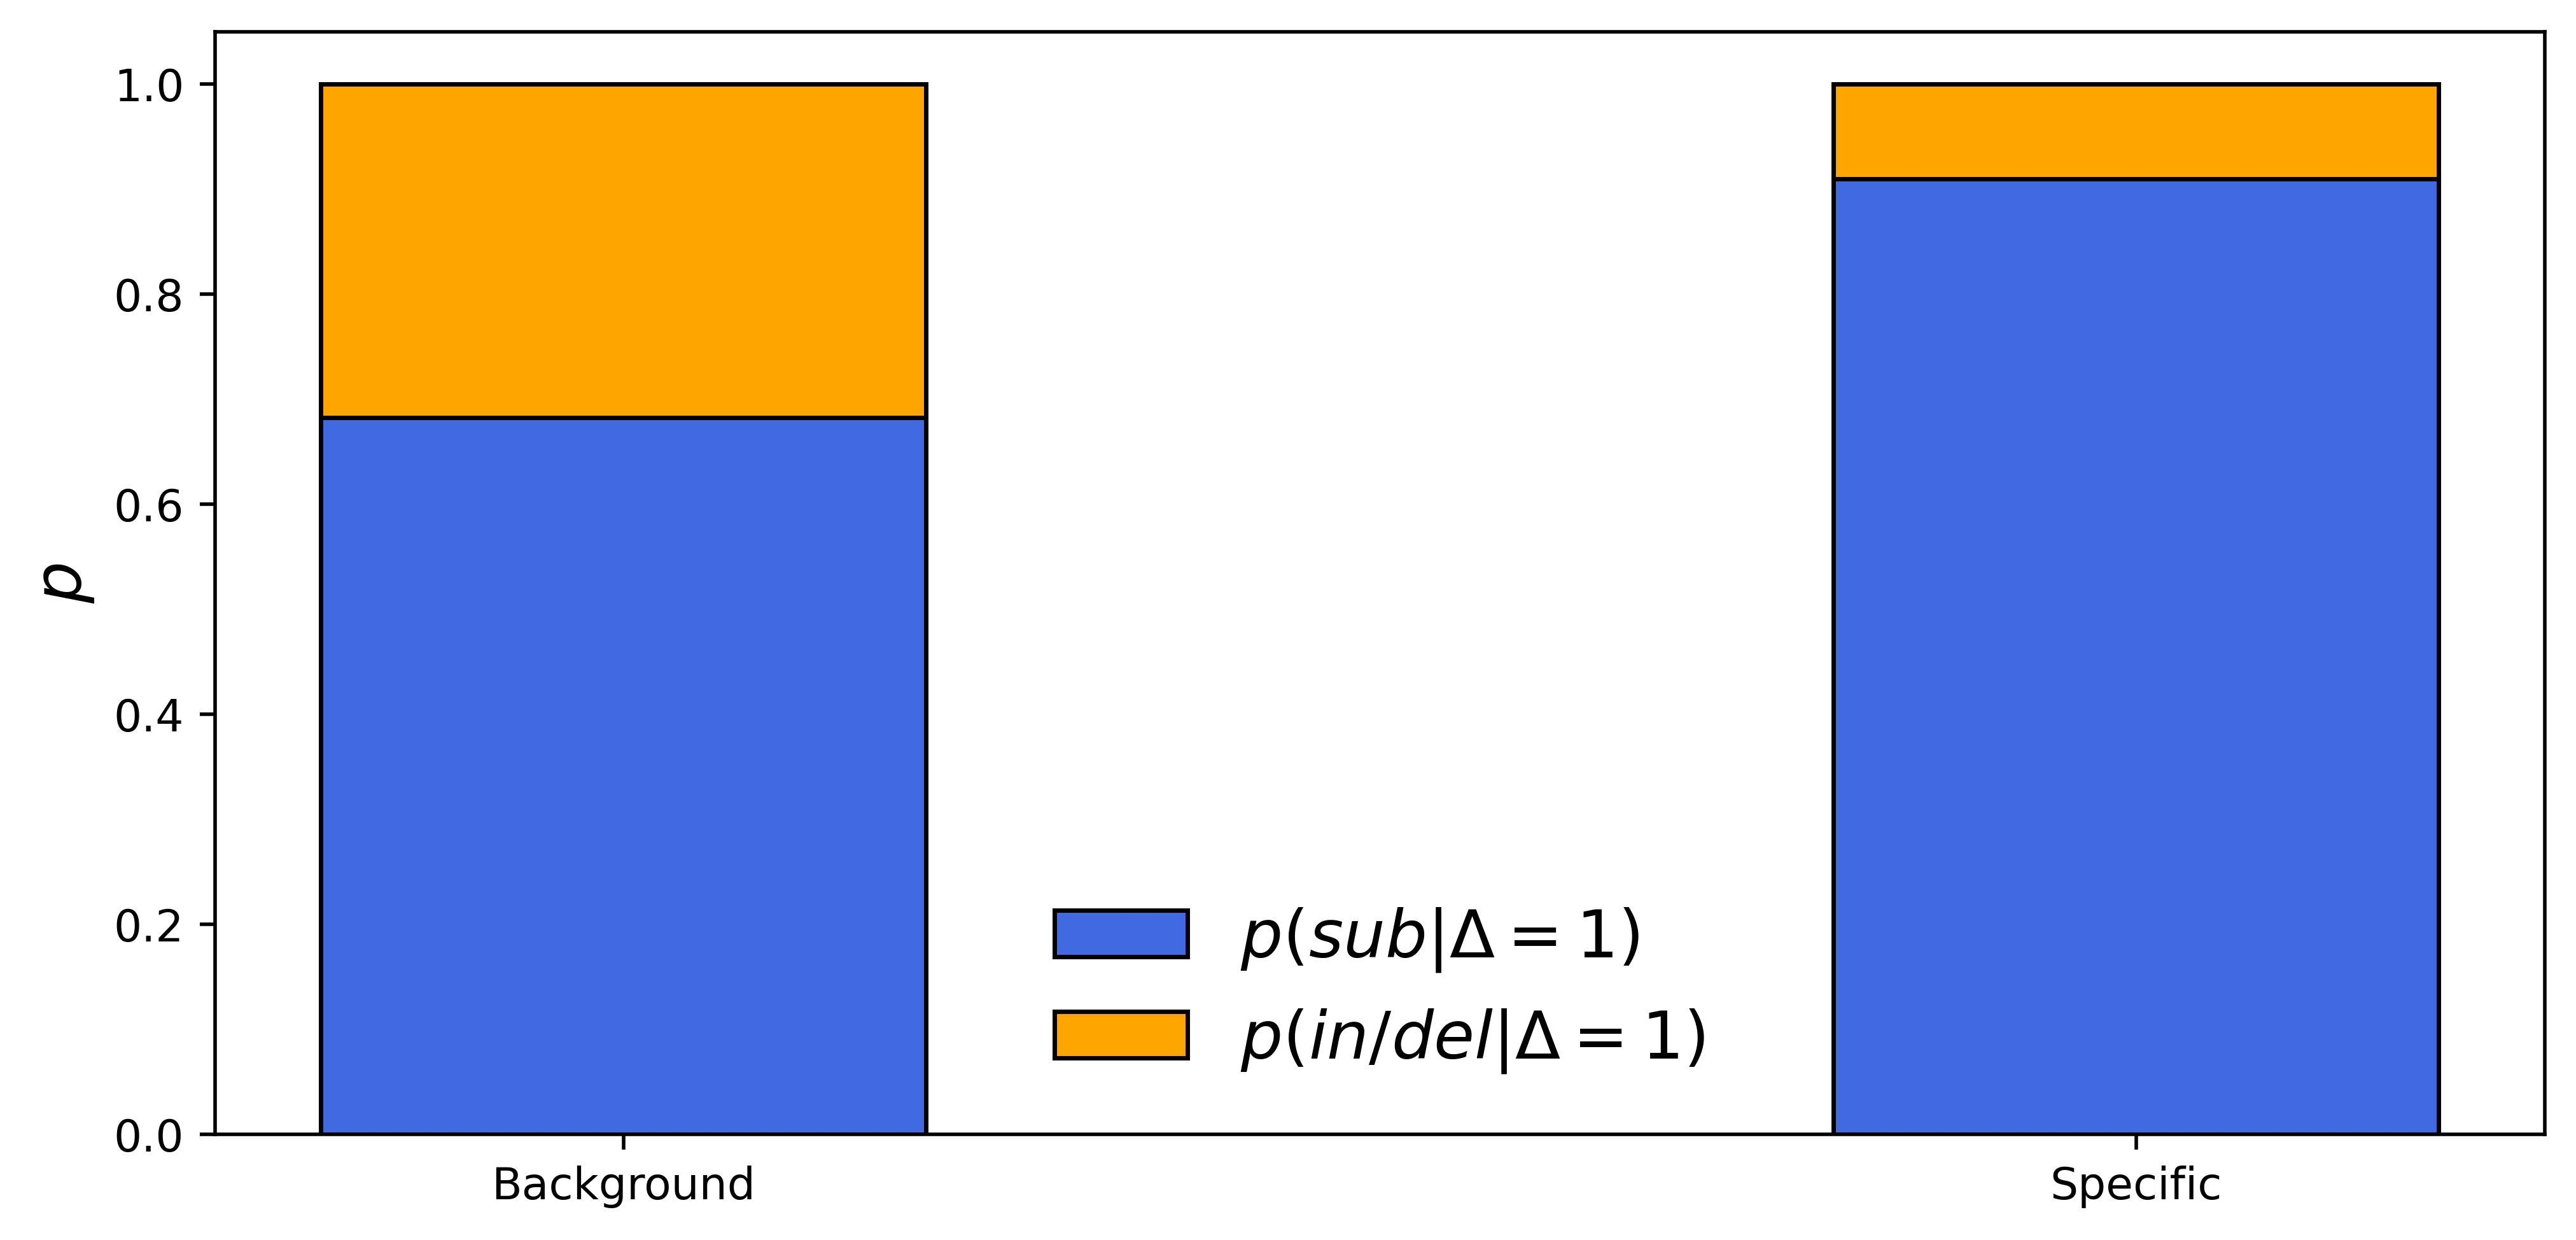

In [8]:
fig,ax = plt.subplots(figsize=(9,5))
fig.tight_layout(pad=3.0)

bars = ("Background","Specific")
ypos = np.arange(len(bars))

ax.bar(0,p_back[0],color='royalblue', edgecolor = 'black')
ax.bar(0,p_back[1],bottom=p_back[0],color='orange', edgecolor = 'black')
ax.bar(2,p_spc_sub,color='royalblue', edgecolor = 'black')
ax.bar(2,p_spc_indel,bottom=p_spc_sub,color='orange',edgecolor = 'black')


ax.set_ylabel('$p$')
ax.set_xticks([0,2],bars)
ax.legend(["$p(sub|\Delta = 1)$", "$p(in/del|\Delta = 1)$"]);

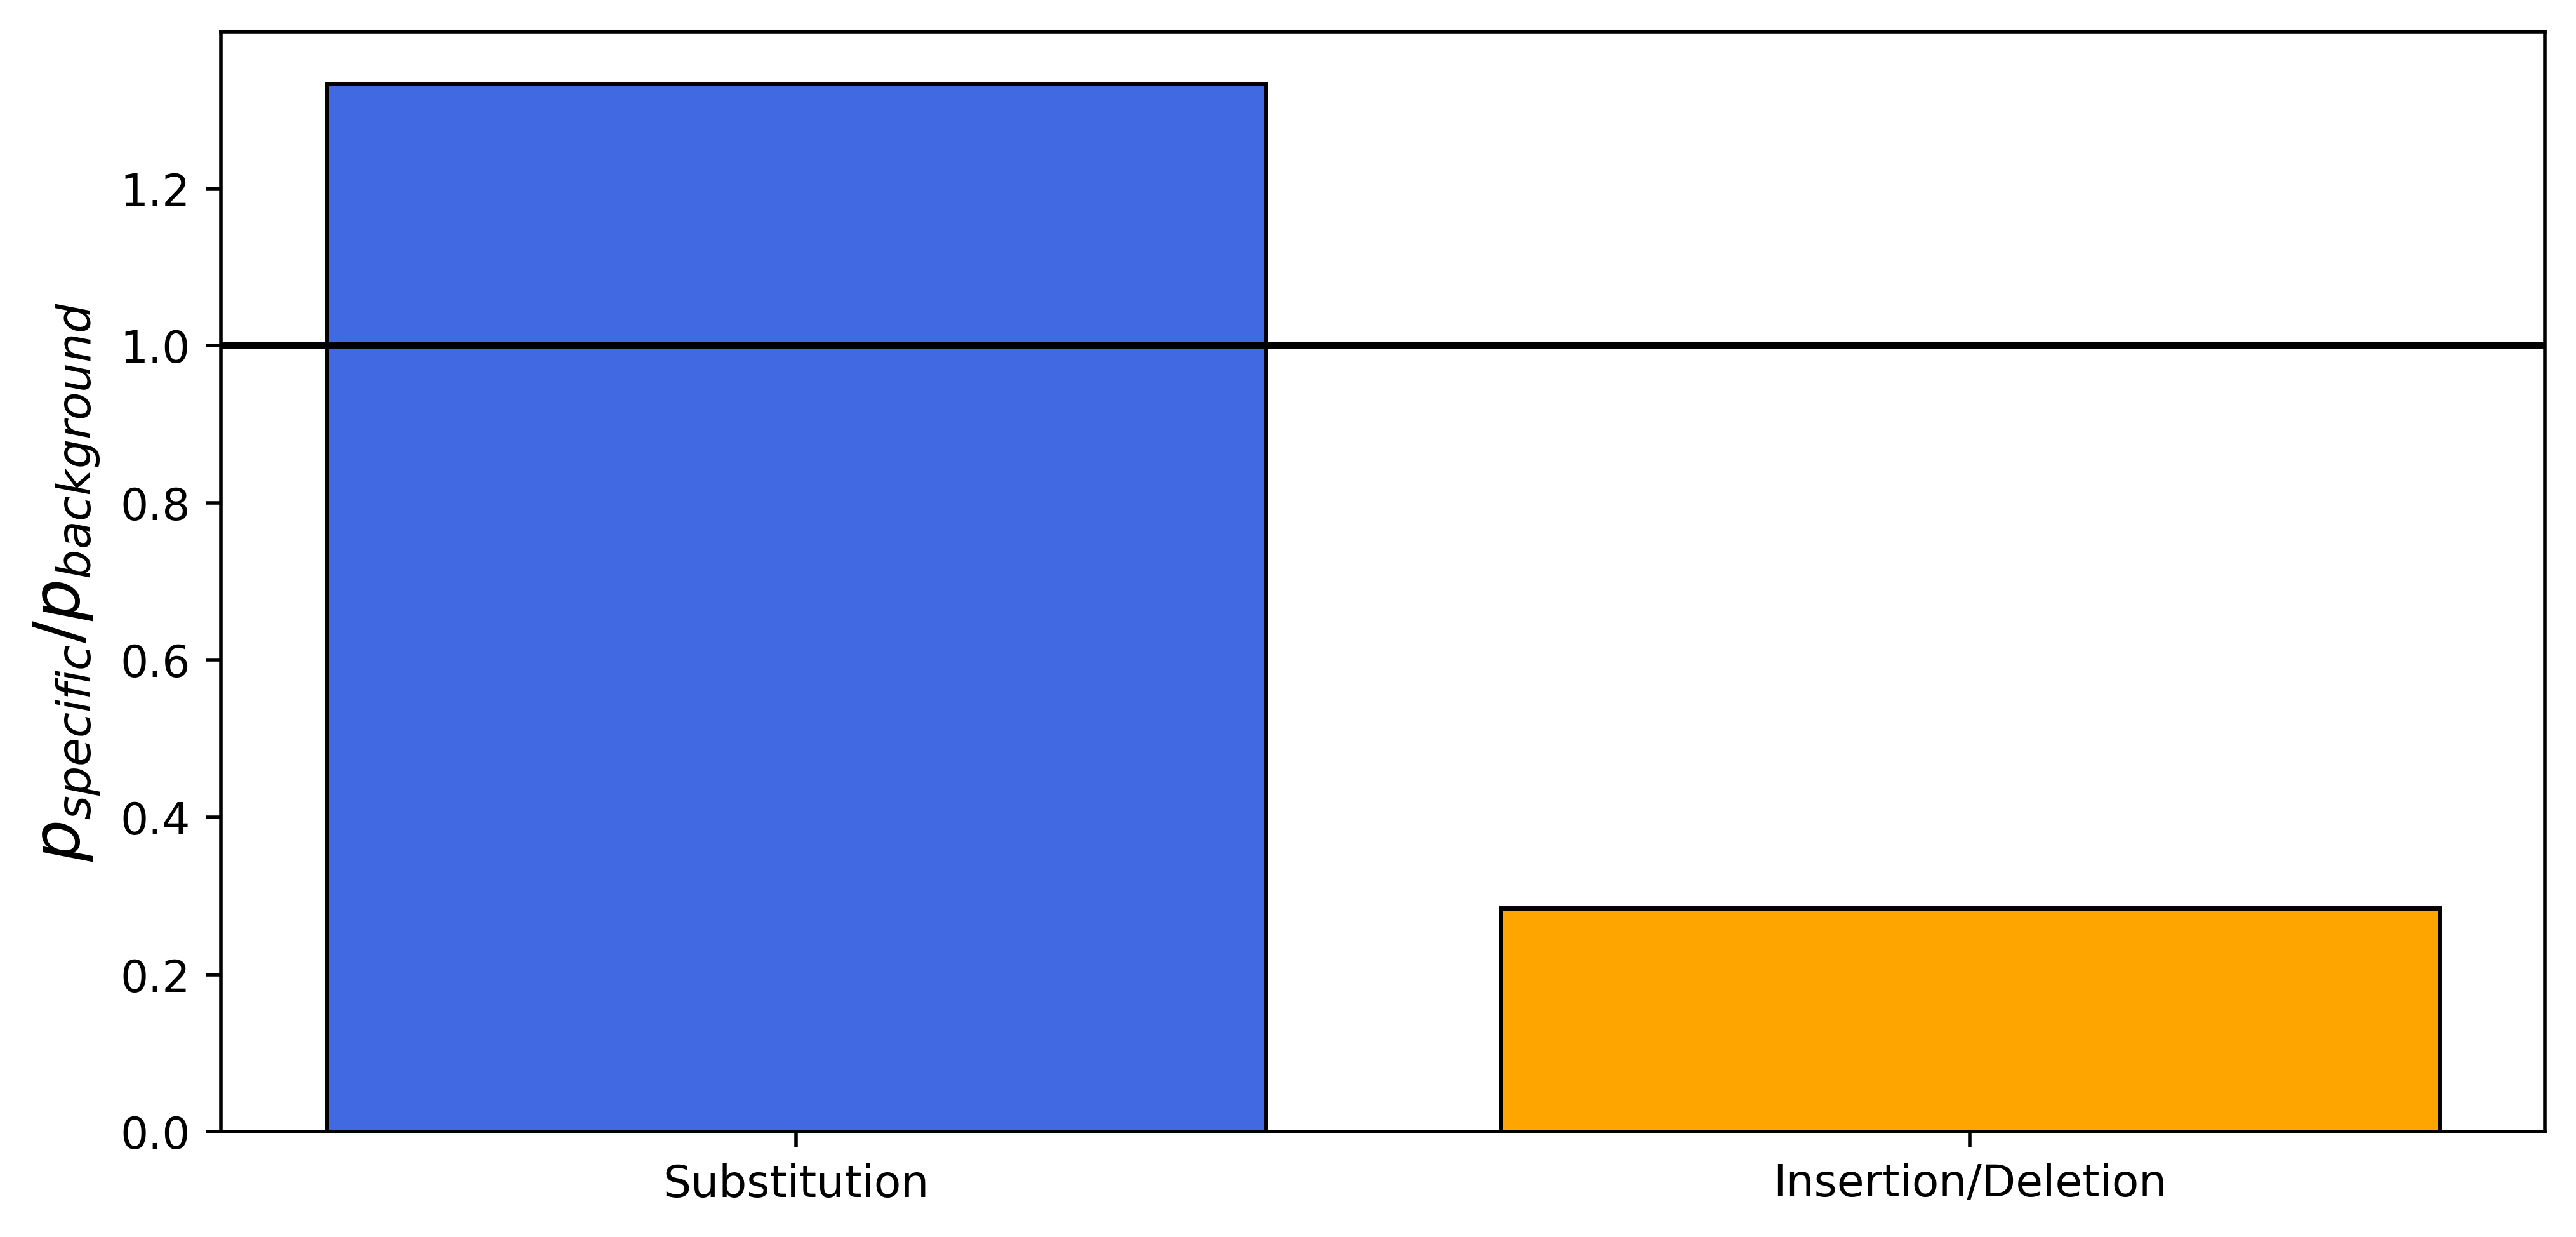

In [9]:
fig,ax = plt.subplots(figsize=(9,5))
fig.tight_layout(pad=3.0)

bars = ("Substitution","Insertion/Deletion")
ypos = np.arange(len(bars))


ax.bar(1,p_spc_sub/p_back[0],color='royalblue',edgecolor = 'black')
ax.bar(2,p_spc_indel/p_back[1],color='orange',edgecolor = 'black')

ax.set_ylabel(r"$p_{specific}/p_{background}$")
ax.set_xticks([1,2],bars)

ax.axhline(1, c='black');

We can see that insertions and deletions occur less frequently in both specific and background sequences. However, specific sequences are much more likely to differ by a single edit when compared to background sequences.

## Probability of shared specificty given edit type

We will now look at the average probability that two sequences are specific, given that they are edit distance $\Delta = 1$ and differ by either a substitution or an insertion/deletion. To obtain this quantity we need to follow the procedure below: 

$$\left< p_s (\text{edit type})| \Delta = 1 \right> = f_{spc} \frac{p_C(\Delta = 1)}{p_{C,back}(\Delta = 1)} \frac{P(\text{edit type}|\Delta = 1)}{P_{back}(\text{edit type}| \Delta = 1)}$$

The fraction of specific sequences is obtained from:

$$f_{spc} = \frac{p_{C,back}(\Delta = 0)}{p_C(\Delta = 0)}$$

In [10]:
pcD_back = prs.load_pcDelta_background(return_bins=True)[0]["beta"]
pcD_spc = pd.read_csv('mira_pcd_spc.csv').set_index('Delta')["0"]

In [11]:
f_spc = pcD_back[0]/pcD_spc[0]
ratio_delta_1 = pcD_spc[1]/pcD_back[1]

In [12]:
p_s_sub = f_spc*ratio_delta_1*p_spc_sub/p_back[0]
p_s_indel = f_spc*ratio_delta_1*p_spc_indel/p_back[1]

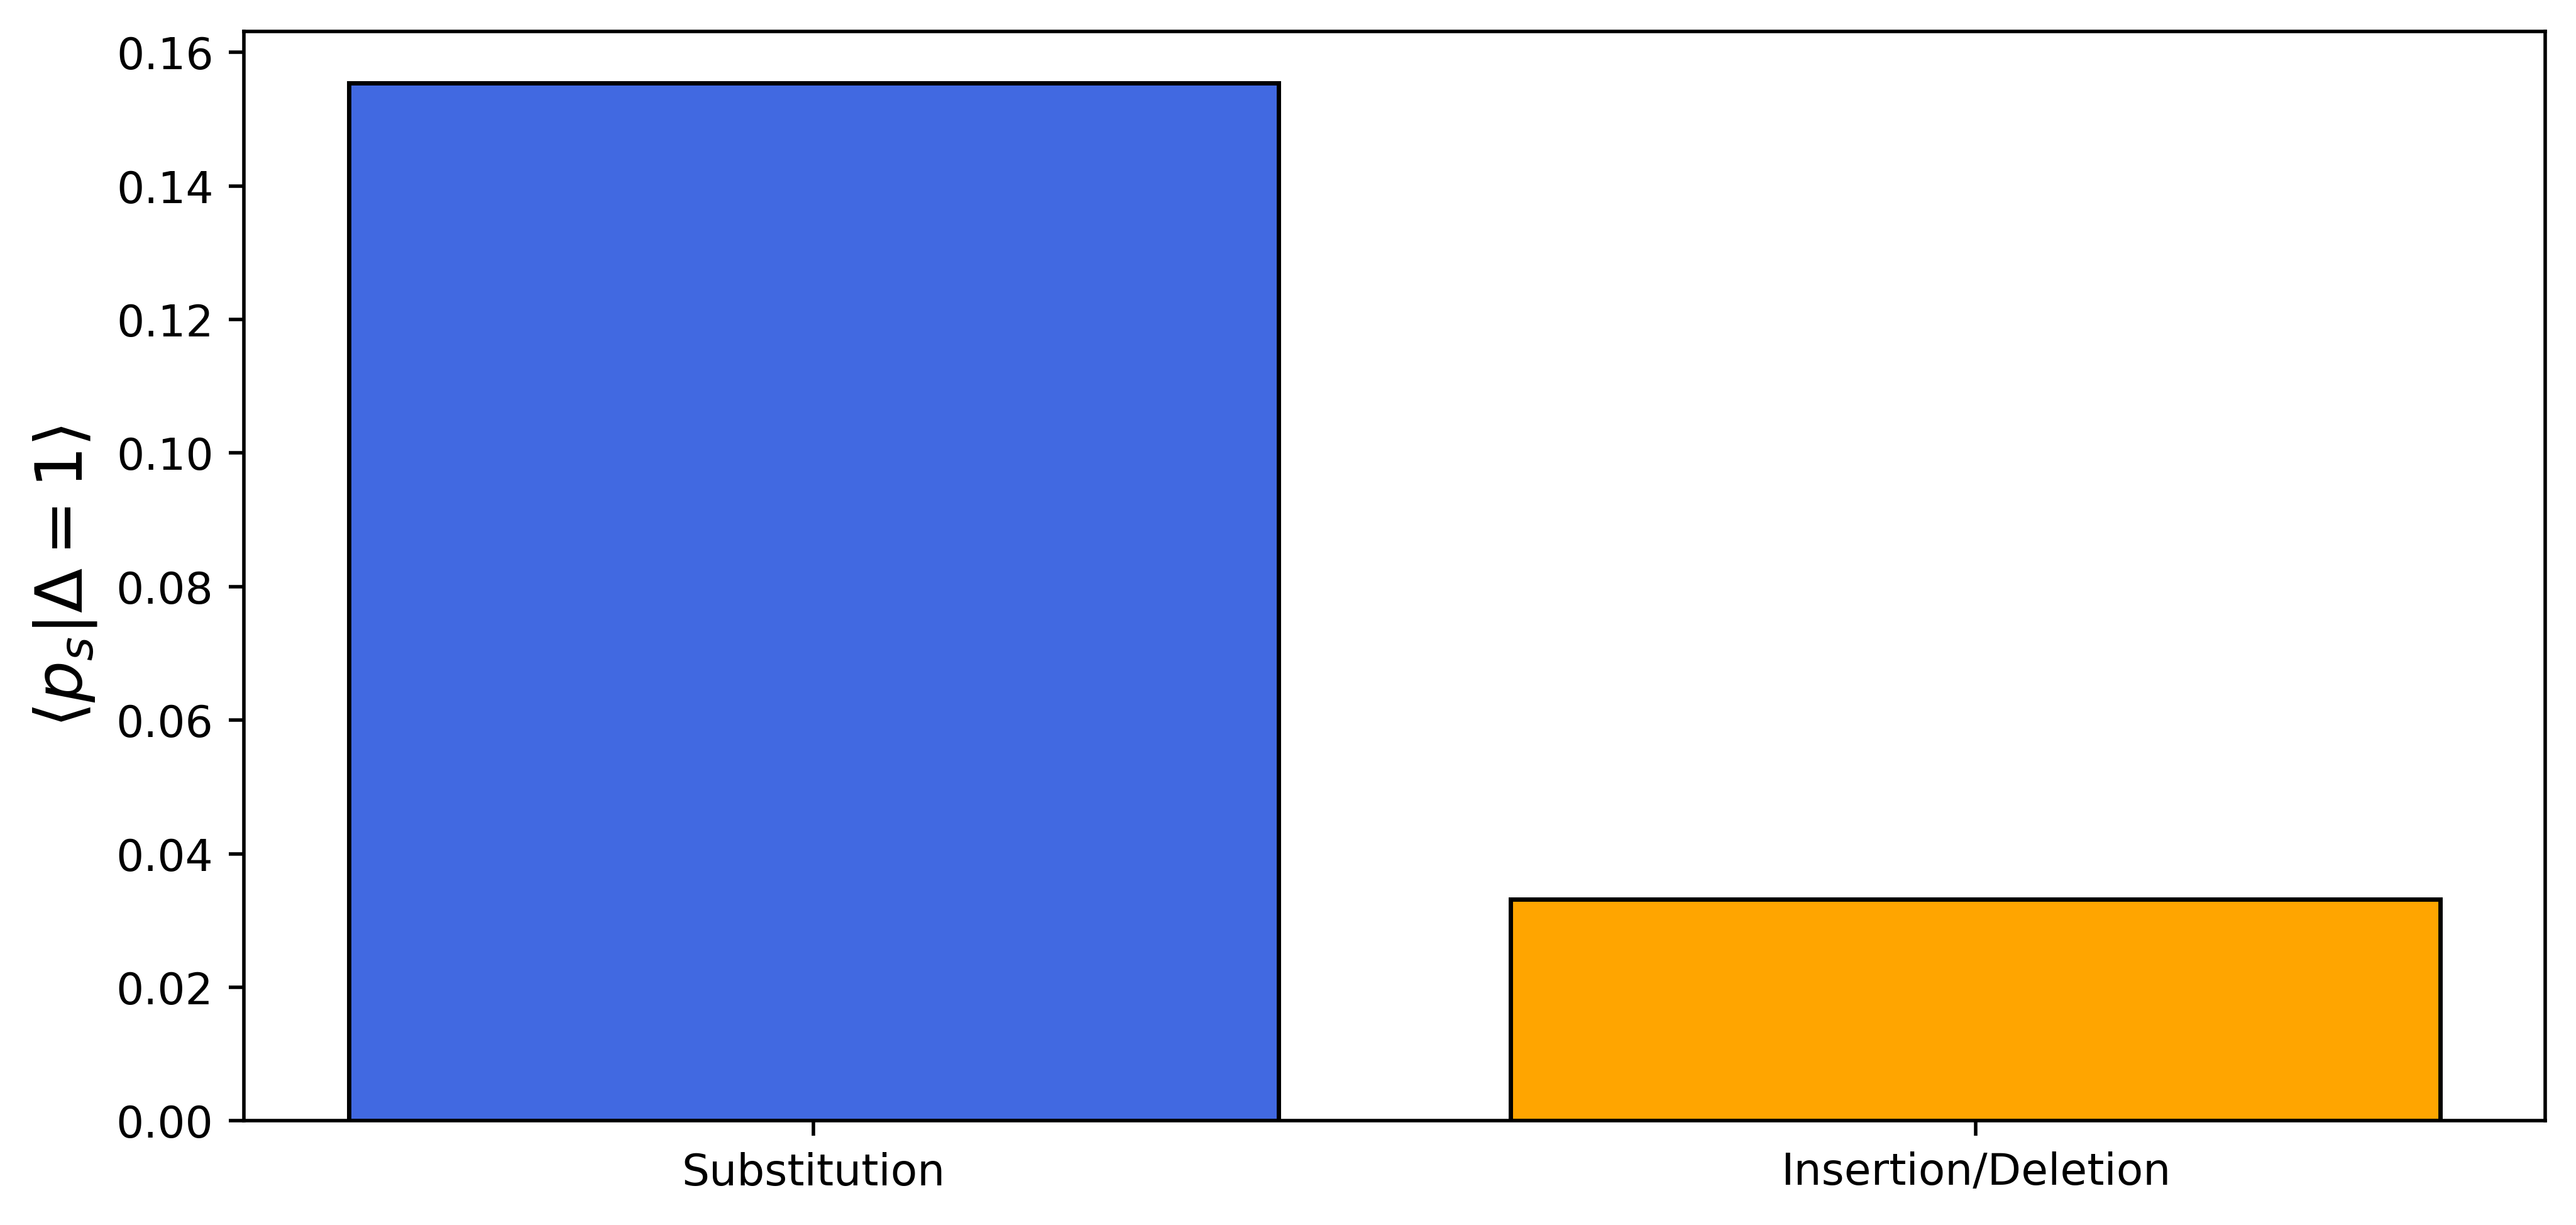

In [13]:
fig,ax = plt.subplots(figsize=(9,5))
fig.tight_layout(pad=3.0)

bars = ("Substitution","Insertion/Deletion")
ypos = np.arange(len(bars))

ax.bar(1,p_s_sub,color='royalblue',edgecolor = 'black')
ax.bar(2,p_s_indel,color='orange',edgecolor = 'black')

ax.set_ylabel(r"$\left< p_s | \Delta = 1\right>$")
ax.set_xticks([1,2],bars);

In [14]:
print(f"Shared specificty enhancement ratio: {p_s_sub/p_s_indel}")

Shared specificty enhancement ratio: 4.688072052099208


This tells us that for sequences $\Delta = 1$ apart, they are around $4$ times more likely to be specific to the same epitope if that edit was a substitution compared to if it was an insertion or a deletion.

## Extending the analysis for increasing number of edits 

We will now look at increasing the number of edits. Here we will be counting the number of pairs that differ by $\Delta$ substitutions compared to any other set of edits

In [15]:
from Levenshtein import hamming as hamming_distance
from Levenshtein import distance as levenshtein_distance

In [16]:
def pdist(strings, metric=None, dtype=float, **kwargs):
    
    if metric is None:
        metric = levenshtein_distance
    strings = list(strings)
    m = len(strings)
    dm = np.empty((m * (m - 1)) // 2, dtype=dtype)
    k = 0
    for i in range(0, m-1):
        for j in range(i+1, m):
            try:
                dm[k] = metric(strings[i], strings[j], **kwargs)
            except:
                dm[k] = np.nan #Reworked pdist so that if the distance metric fails a NaN is returned
               
            k += 1
    
    return dm

In [17]:
def p_edit_type_at_distance(hamming_distances, levenshtein_distances, search_distance, normalize = True):
    
    #Calculate the number of hamming neighbors
    sub_pairs = len(hamming_distances[hamming_distances == search_distance])
    
    #Calculate the number of levenshtein neighbors - subtract hamming neighbors to get insertion and deletions
    in_del_pairs = len(levenshtein_distances[levenshtein_distances == search_distance]) - sub_pairs
    
    #Work out the total number of neighbors
    N_at_distance = sub_pairs+in_del_pairs
        
    if not normalize:
        return sub_pairs, in_del_pairs
        
    else:
        return (sub_pairs/N_at_distance,in_del_pairs/N_at_distance)

### pdist vectors

In [ ]:
back_sample = back.sample(2000)

back_hamming_distances = pdist(back_sample["CDR3B"], metric=hamming_distance)
back_levenshtein_distances = pdist(back_sample["CDR3B"])

In [ ]:
#Get the distances for the group
grouped_hamming_distances = []
grouped_levenshtein_distances = []
for epitope, group in mira.sample(20000).groupby('Epitope'):
    
    grouped_hamming_distances.append(pdist(group["CDR3B"], metric=hamming_distance))
    grouped_levenshtein_distances.append(pdist(group["CDR3B"]))

In [ ]:
d_max = 8
distances = np.arange(1,d_max)

### Background analysis

Here we will run the analysis on the background set:

In [ ]:
pd_back_sub = []
pd_back_indel = []
for distance in distances:
    
    p_for_distance = p_edit_type_at_distance(back_hamming_distances, back_levenshtein_distances, distance)
    
    pd_back_sub.append(p_for_distance[0])
    pd_back_indel.append(p_for_distance[1])
    
pd_back_sub = np.array(pd_back_sub)
pd_back_indel = np.array(pd_back_indel)

### Specific analysis 

We will now run the same code but on mira sequences, grouped by their epitope

In [ ]:
pd_spc_sub = []
pd_spc_indel = []
for distance in distances:
    
    p_sub_for_distance = []
    p_indel_for_distance  = []
    
    #Group data set via epitope
    for group_hamming_distances, group_levenshtein_distances in zip(grouped_hamming_distances,grouped_levenshtein_distances):
    
        #Get the probabilities within each epitope
        sub,indel = p_edit_type_at_distance(group_hamming_distances, group_levenshtein_distances, distance, normalize = False)
    
        p_sub_for_distance.append(sub)
        p_indel_for_distance.append(indel)

        
    p_sub_for_distance = np.array(p_sub_for_distance)
    p_indel_for_distance = np.array(p_indel_for_distance)

    N_at_distance = p_sub_for_distance+p_indel_for_distance

    #Normalize
    pd_spc_sub.append(np.mean(p_sub_for_distance)/np.mean(N_at_distance))
    pd_spc_indel.append(np.mean(p_indel_for_distance)/np.mean(N_at_distance))
    
pd_spc_sub = np.array(pd_spc_sub)
pd_spc_indel = np.array(pd_spc_indel)

### Results

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5))


ax[0].plot(distances, pd_back_sub, label = "pure substitutions", c= 'royalblue')
ax[0].plot(distances, pd_back_indel, label = "other", c = 'orange');
ax[0].set_ylabel('$p$')
ax[0].set_xlabel("$\Delta$CDR3B")
ax[0].set_title("Background")
ax[0].set_ylim([0,1])
ax[0].legend()

ax[1].plot(distances, pd_spc_sub, label = "substitutions", c = 'royalblue')
ax[1].plot(distances, pd_spc_indel, label = "other", c = 'orange')
ax[1].set_ylabel('$p$')
ax[1].set_xlabel("$\Delta$CDR3B")
ax[1].set_title("Specific")
ax[1].set_ylim([0,1])
ax[1].legend();

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(distances, pd_spc_sub/pd_back_sub, label = "pure substitutions", c= 'royalblue')
ax.plot(distances, pd_spc_indel/pd_back_indel, label = "other", c = 'orange');
ax.set_ylabel('$p/p_{back}$')
ax.set_xlabel("$\Delta$CDR3B")
ax.legend()
ax.axhline(1, c = 'black', linestyle = '--', alpha = 0.5);

In [25]:
ratio_delta_1 = pcD_spc[1:d_max]/pcD_back[1:d_max]
pd_s_sub = f_spc*ratio_delta_1*pd_spc_sub/pd_back_sub
pd_s_indel = f_spc*ratio_delta_1*pd_spc_indel/pd_back_indel

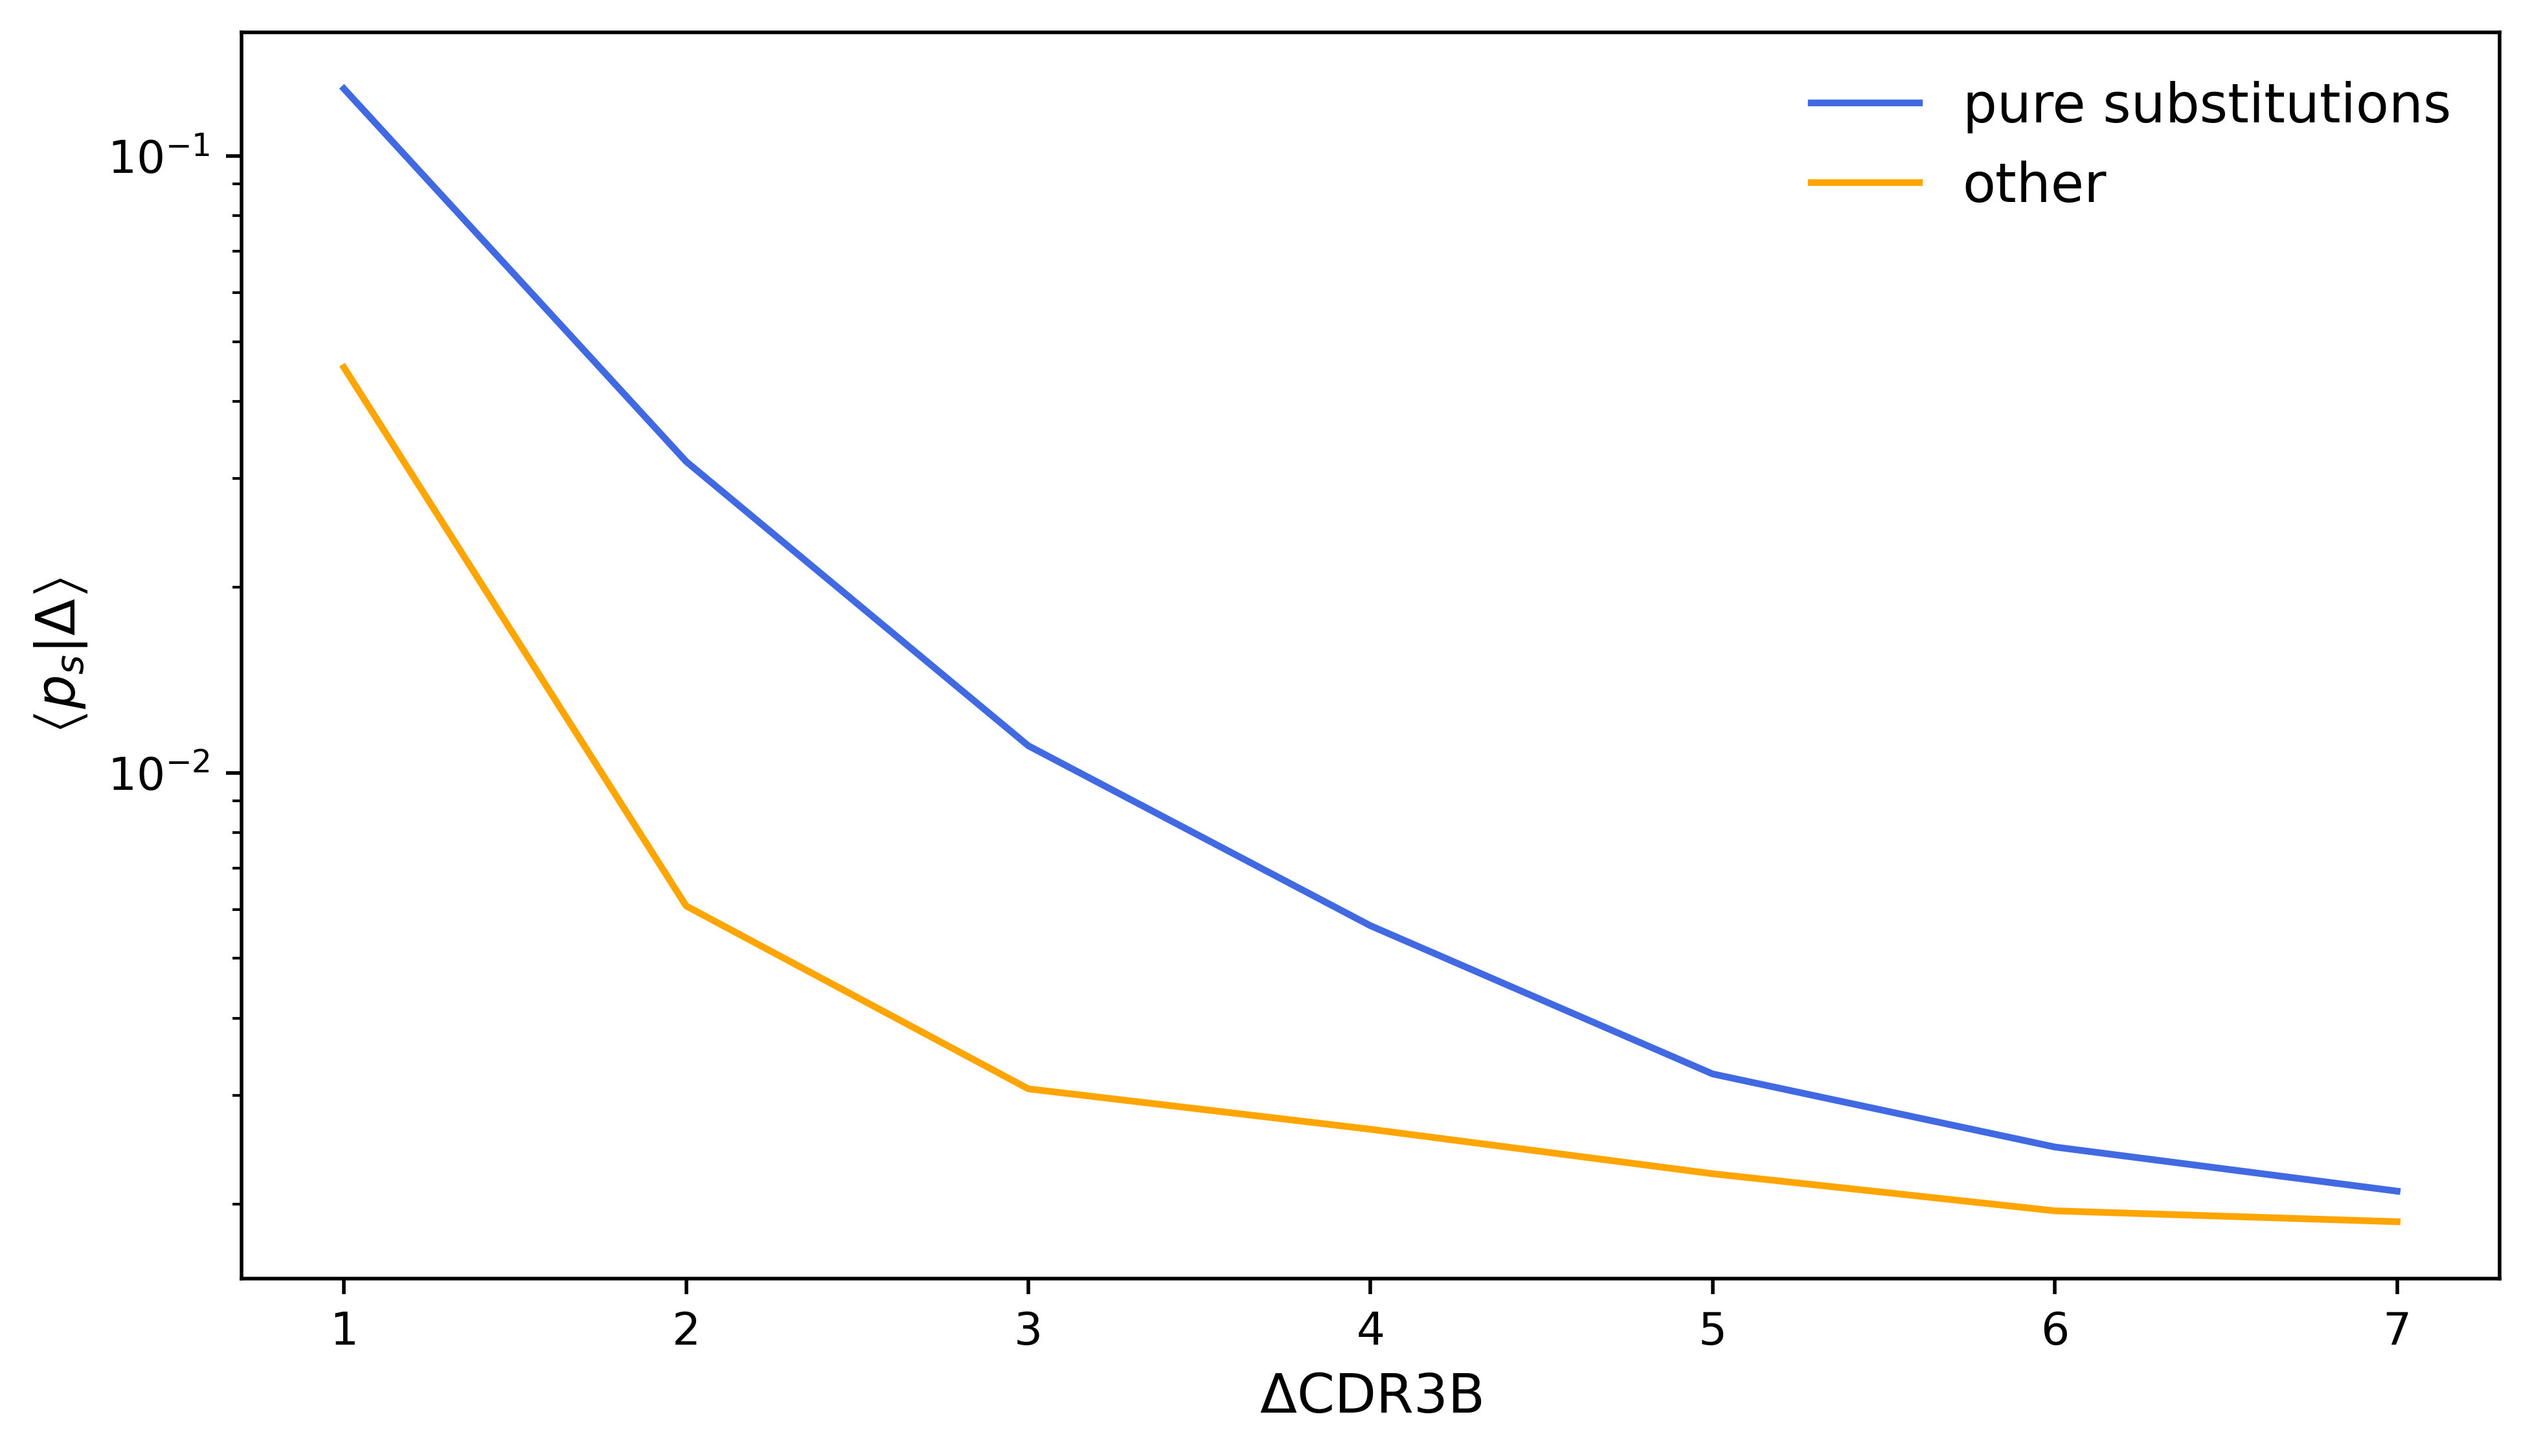

In [26]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(distances, pd_s_sub, label = "pure substitutions", c= 'royalblue')
ax.plot(distances, pd_s_indel, label = "other", c = 'orange');
ax.set_ylabel(r"$\left< p_s | \Delta\right>$")
ax.set_xlabel("$\Delta$CDR3B")
ax.set_yscale('log')
ax.legend();

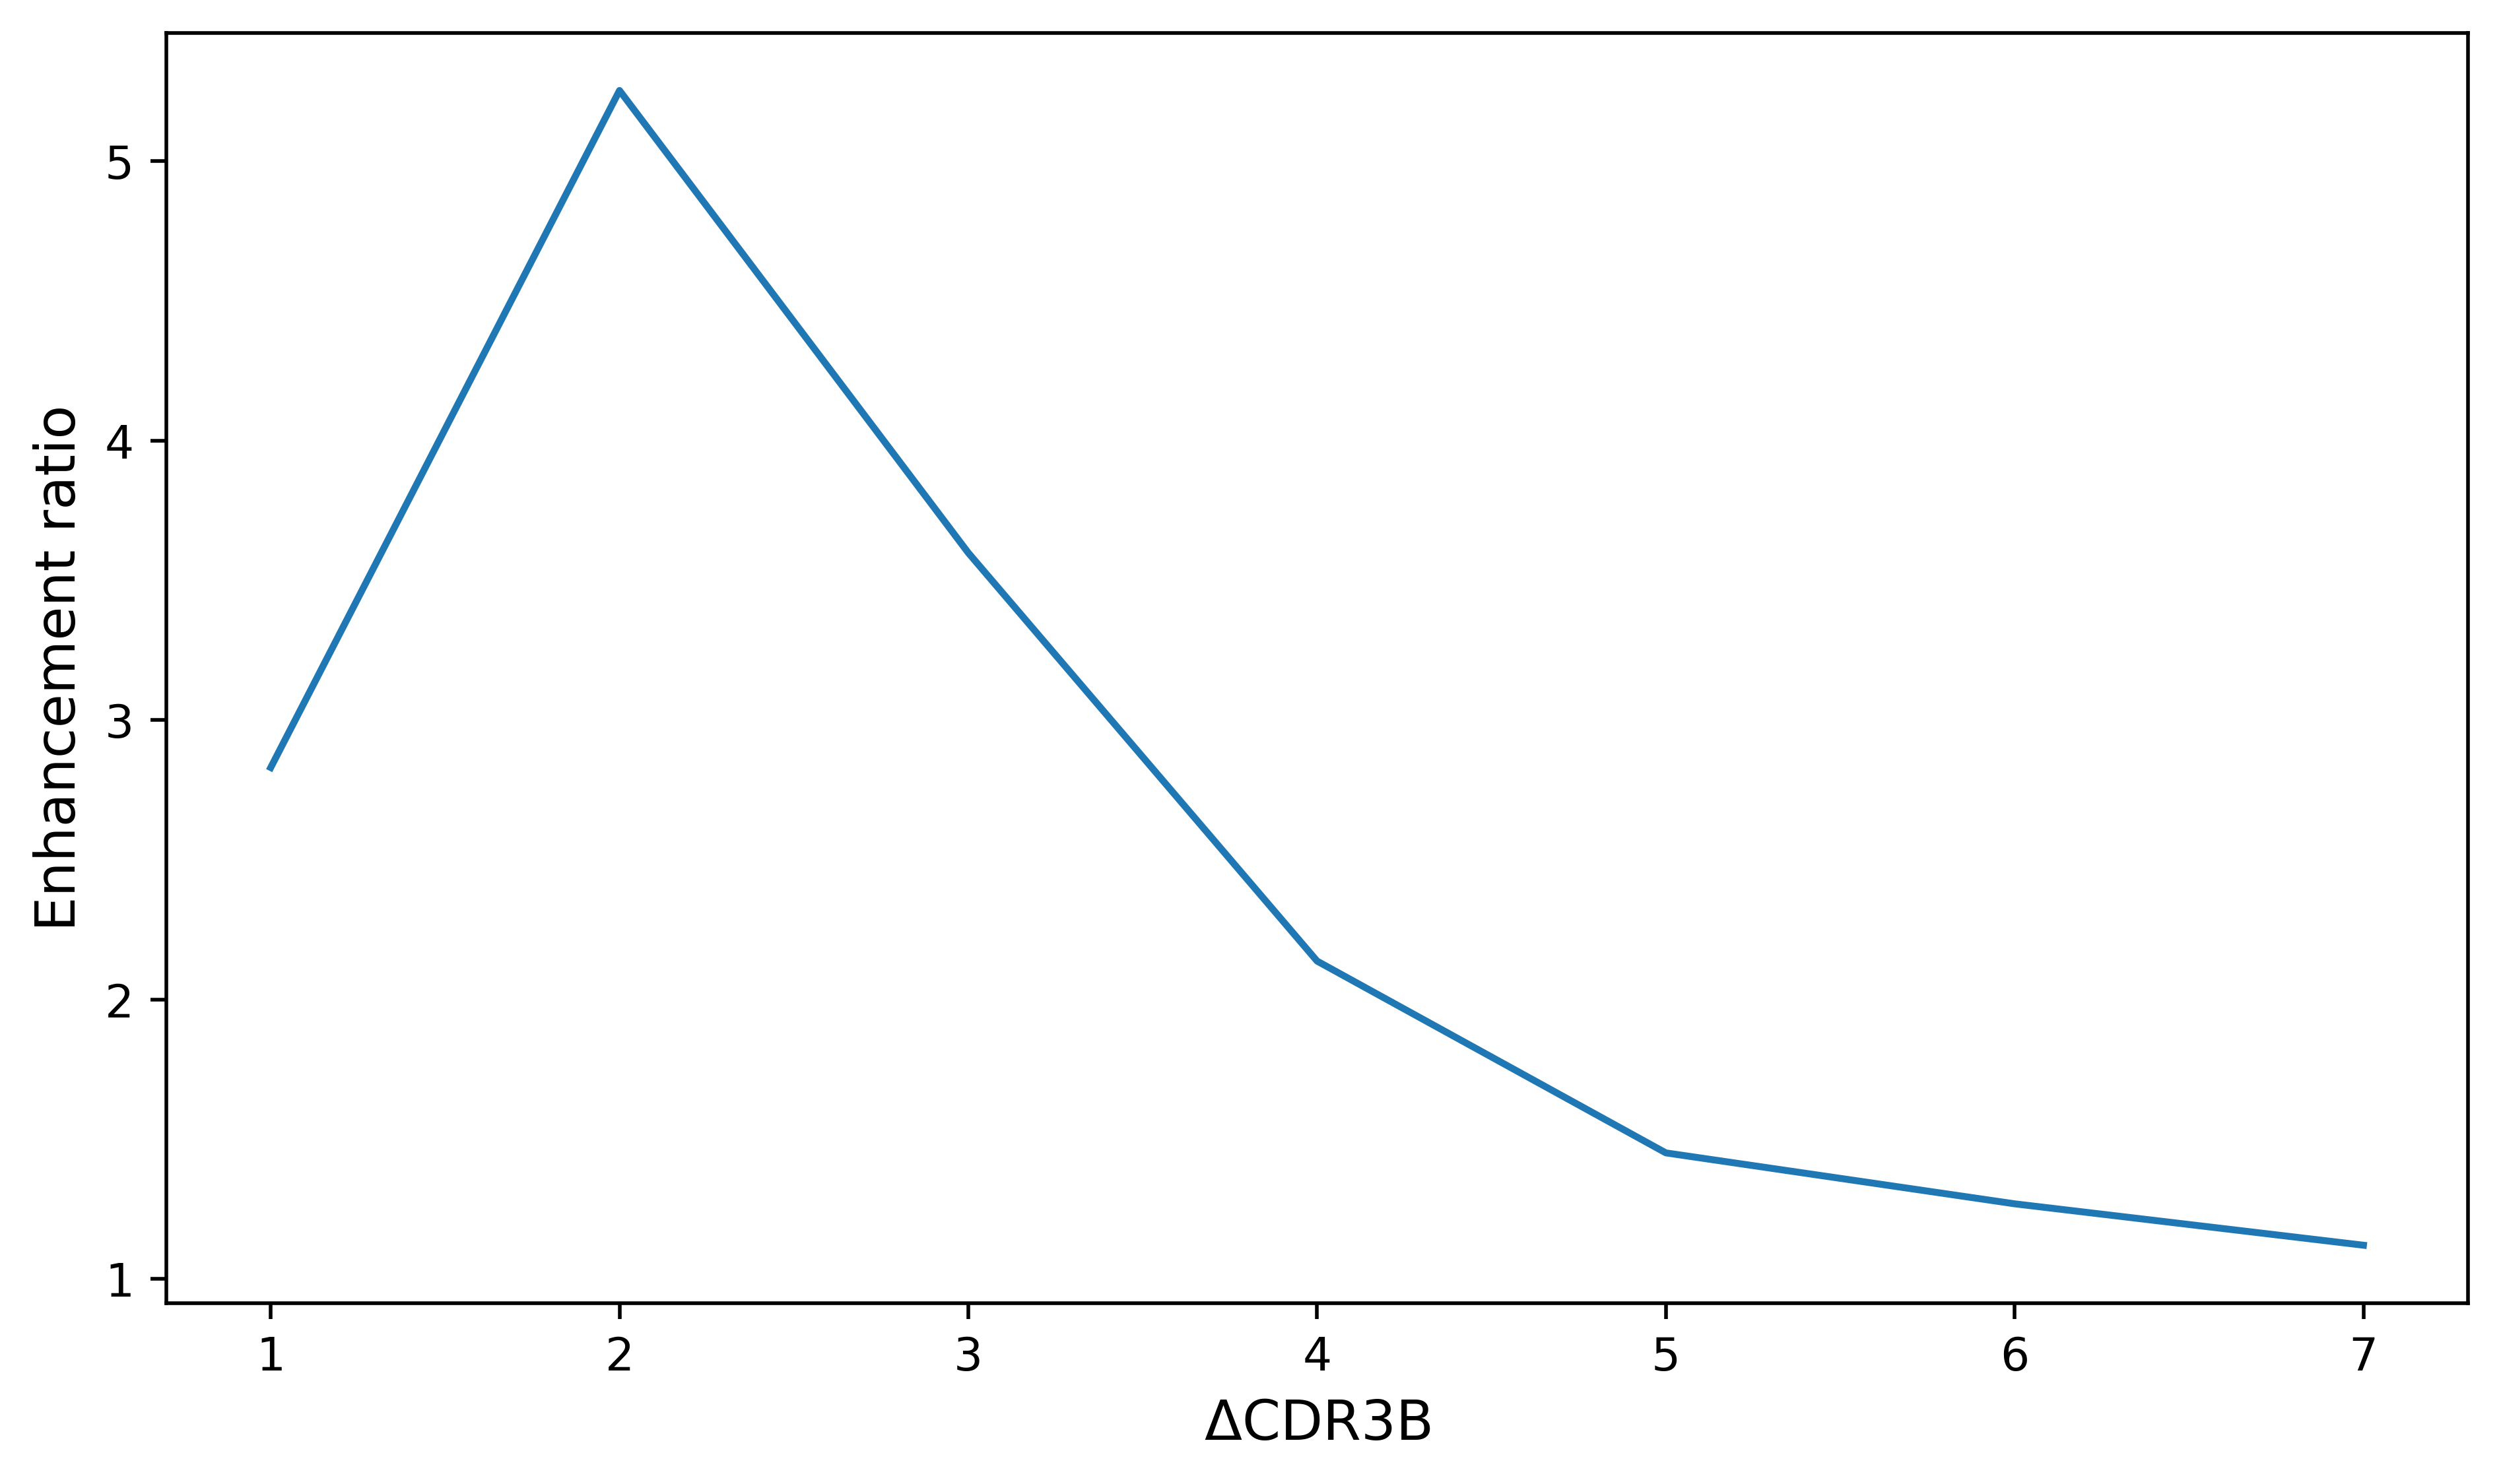

In [27]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(distances, pd_s_sub/pd_s_indel)
ax.set_ylabel("Enhancement ratio")
ax.set_xlabel("$\Delta$CDR3B");